## Diversity analysis for the TSCA Active constrained inventory

Last modified: 11 May 2024<br>
Change: Updating to account for the new inventory. This notebook captures the analysis to identify the number of diverse substances ideally needed for testing to achieve a set threshold of structural diversity. Comparable to notebook 07, this one addresses a constrained inventory of only looking at the TSCA active inventory.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform
import sys

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [3]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

#### Updating since TSCA status has changed

In [4]:
from model_functions import *

In [5]:
df = pd.read_excel(interim_dir+'final_universe_categorisations_wCDR_100524.xlsx')

In [6]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,Substance_Note,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,...,tsca_dist,MaxMin_tsca_picks,tsca_active_centroid,tsca_active_centroid_id,tsca_active_centroid_id2,tsca_active_analogues,tsca_active_dist,MaxMin_tsca_active_picks,CDR2019_NATIONAL_AGG_PV,CDR2020_STATUS
0,IROQAHVXXUQBOS-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,CCCN(CCNC(=O)c1ccc(Cc2ccc(C(O)=O)cc2)cc1)S(=O)...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DTXSID90897582,DSSTox_High,4-(Perfluorononyl)oxybenzenesulfonate sodium,91998-13-9,Single Compound,NaN,[Na+].[O-]S(=O)(=O)C1=CC=C(OC(F)(F)C(F)(F)C(F)...,"InChI=1S/C15H5F19O4S.Na/c16-7(17,8(18,19)10(22...",WEKFOCTWTWPVEG-UHFFFAOYSA-M,C15H4F19NaO4S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DTXSID90896257,Public_Low,(2S)-2-{Bis[4-(heptadecafluorooctyl)phenyl][(t...,914391-37-0,Single Compound,NaN,CC[Si](CC)(CC)OC([C@@H]1CCCN1)(C1=CC=C(C=C1)C(...,"InChI=1S/C39H31F34NOSi/c1-4-76(5-2,6-3)75-23(2...",PARYPNCCAOUHML-QFIPXVFZSA-N,C39H31F34NOSi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DTXSID90896196,Public_Low,"2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,9-Heptadecaflu...",157584-47-9,Single Compound,NaN,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,"InChI=1S/C21H10F17NO/c22-14(23,13(40)39(11-7-3...",IDJHICNQDCLWAB-UHFFFAOYSA-N,C21H10F17NO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DTXSID90896095,Public_Low,"3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadeca...",113823-56-6,Single Compound,NaN,CC1=CC=C(C=C1)S(=O)(=O)OCCC(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C17H11F17O3S/c1-8-2-4-9(5-3-8)38(35,3...",WGCSEECKLMOBLT-UHFFFAOYSA-N,C17H11F17O3S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Constraining the universe to TSCA and computing centroids and MaxMin from the contrained inventory

Calculate centroids for terminal categories but constraining the substances to those with substances on the TSCA ACTIVE inventory

In [7]:
pfas_tsca = df[df['TSCA_STATUS']== 'active']

In [8]:
pfas_tsca.shape

(237, 209)

In [9]:
results_subcats = {}
for i, group in pfas_tsca.groupby('group_str'):
    try:
        a = mk_fp(group)
    except Exception as error:
        print(error)
    else:
        results_subcats[i] = a


In [10]:
distances_subcats = {}
for k,v in results_subcats.items():
    a = distance_matrix(results_subcats[k])
    distances_subcats[k] = a

In [11]:
len(results_subcats)


60

In [12]:
len({k:v.shape[0] for k,v in results_subcats.items() if v.shape[0] >5})

14

In [13]:
len(distances_subcats)

60

In [14]:
centres = []
for i,group in pfas_tsca.groupby('group_str'):
    try:
        m = medoid_calc(distances_subcats[i])
        centres.append(m)
    except Exception as error:
        print(error)


In [15]:
pfas_tsca['tsca_centroid'] = pfas_tsca['dtxsid'].apply(lambda x: 'centroid' if x in centres else np.nan)

/tmp/ipykernel_3591362/1021335603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfas_tsca['tsca_centroid'] = pfas_tsca['dtxsid'].apply(lambda x: 'centroid' if x in centres else np.nan)


In [16]:
pfas_tsca.tsca_centroid.value_counts()

centroid    60
Name: tsca_centroid, dtype: int64

In [17]:
df3 = pfas_tsca.copy()

In [18]:
df_3 = df3.set_index('dtxsid')

In [19]:
members = {}

for i, group in df_3.groupby('group_str'):
    subset = group[['group_str', 'tsca_centroid']]
    try: 
        for x, y in subset.iterrows():
            a, b = y
            if b == 'centroid':
                #print(x)
                c = [distances_subcats[i][x].index, distances_subcats[i][x].values]
                members[x] = c
    except Exception as error:
            print(error)

In [20]:
cluster_members = pd.DataFrame(list(members.items()))
cluster_members.columns = ['tsca_centroid', 1]
cluster_members[['lvl2_analogues','lvl2_Dist']] = pd.DataFrame(cluster_members[1].tolist(), index= cluster_members.index)
cluster_members.drop([1], axis = 1, inplace = True)
cluster_members_1 = cluster_members.apply(pd.Series.explode)
cluster_members_1.head()


,tsca_centroid,lvl2_analogues,lvl2_Dist
0,DTXSID4069501,DTXSID4069501,0.0
1,DTXSID60865157,DTXSID60865157,0.0
2,DTXSID70889167,DTXSID70889167,0.0
3,DTXSID00883911,DTXSID00883911,0.0
4,DTXSID1024251,DTXSID70883382,0.571429


In [21]:
df3['tsca_centroid_id'] = df3.apply(lambda x: x['dtxsid'] if x['tsca_centroid'] == 'centroid' else np.nan, axis = 1)


In [22]:
df3 = df3.sort_values(by = ['group_str', 'tsca_centroid_id'], ascending = [True, False])

In [23]:
df3['tsca_centroid_id2'] = df3['tsca_centroid_id'].fillna(method = 'ffill')


In [24]:
mydict_ = {}
for i, group in df3.groupby('tsca_centroid_id2'):
    k = [n for n in group['tsca_centroid_id2'] if n != ' '][0]
    v = list(group['dtxsid'])
    mydict_[k] = v


In [25]:
len(list(mydict_.values()))

60

In [26]:
dist_ = []
for i, group in cluster_members_1.groupby('tsca_centroid'):
    a = cluster_members_1[(cluster_members_1['tsca_centroid'] == i) & (cluster_members_1['lvl2_analogues'].isin(mydict_[i]))]
    dist_.append(a)

In [27]:
dist_df = pd.concat([e for e in dist_])

In [28]:
df3_w = pd.merge(df3, dist_df[['lvl2_analogues', 'lvl2_Dist']], left_on = 'dtxsid', right_on = 'lvl2_analogues', how = 'left')


In [29]:
df3_w.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'Substance_Note', 'smiles', 'Structure_InChI',
       'Structure_InChIKey', 'Structure_Formula',
       ...
       'tsca_active_centroid', 'tsca_active_centroid_id',
       'tsca_active_centroid_id2', 'tsca_active_analogues', 'tsca_active_dist',
       'MaxMin_tsca_active_picks', 'CDR2019_NATIONAL_AGG_PV', 'CDR2020_STATUS',
       'lvl2_analogues_y', 'lvl2_Dist_y'],
      dtype='object', length=211)

In [30]:
df3_w.rename(columns = {'lvl2_analogues_x' : 'lvl2_analogues', 'lvl2_Dist_x' : 'lvl2_Dist', 'lvl2_analogues_y' : 'tsca_analogues' ,'lvl2_Dist_y' : 'tsca_dist'},  inplace = True)

In [31]:
df3_w.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,Substance_Note,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,...,tsca_active_centroid,tsca_active_centroid_id,tsca_active_centroid_id2,tsca_active_analogues,tsca_active_dist,MaxMin_tsca_active_picks,CDR2019_NATIONAL_AGG_PV,CDR2020_STATUS,tsca_analogues,tsca_dist
0,DTXSID4069501,DSSTox_High,N-((Perfluorooctyl)-1-ethyl)pyridinium 4-methy...,61798-68-3,Single Compound,NaN,CC1=CC=C(C=C1)S([O-])(=O)=O.FC(F)(F)C(F)(F)C(F...,"InChI=1S/C15H9F17N.C7H8O3S/c16-8(17,4-7-33-5-2...",ZUDDXBNNEBHAMS-UHFFFAOYSA-M,C22H16F17NO3S,...,centroid,DTXSID4069501,DTXSID4069501,DTXSID4069501,0.0,0.0,NaN,NaN,DTXSID4069501,0.0
1,DTXSID60865157,DSSTox_High,"Pentafluoro(1,2,2-trifluoro-2-((trifluorovinyl...",24520-19-2,Mixture of Stereoisomers,NaN,FC(F)=C(F)OC(F)(F)C(F)(OC1=C(F)C(F)=C(F)C(F)=C...,InChI=1/C11F14O2/c12-1-2(13)4(15)6(5(16)3(1)14...,QYMQYPBAGDZNMY-UHFFFAOYNA-N,C11F14O2,...,centroid,DTXSID60865157,DTXSID60865157,DTXSID60865157,0.0,0.0,NaN,NaN,DTXSID60865157,0.0
2,DTXSID70889167,Public_High_CAS,"2-Propanol, 1-[4-(1-methylpropyl)phenoxy]-3-(2...",308362-88-1,Single Compound,NaN,CCC(C)C1=CC=C(OCC(O)COCC(F)(F)C(F)F)C=C1,InChI=1/C16H22F4O3/c1-3-11(2)12-4-6-14(7-5-12)...,CJBQJVABOFLHNY-UHFFFAOYNA-N,C16H22F4O3,...,centroid,DTXSID70889167,DTXSID70889167,DTXSID70889167,0.0,0.0,NaN,NaN,DTXSID70889167,0.0
3,DTXSID00883911,DSSTox_High,"2-[2,4-Bis(1,1-dimethylpropyl)phenoxy]-N-[4-[(...",2923-93-5,Mixture of Stereoisomers,NaN,CCCCC(OC1=C(C=C(C=C1)C(C)(C)CC)C(C)(C)CC)C(=O)...,InChI=1/C32H41F7N2O4/c1-8-11-12-25(45-24-16-13...,FVSDJPACEHXABM-UHFFFAOYNA-N,C32H41F7N2O4,...,centroid,DTXSID00883911,DTXSID00883911,DTXSID00883911,0.0,0.0,NaN,NaN,DTXSID00883911,0.0
4,DTXSID1024251,DSSTox_High,1H-perfluoroethane,354-33-6,Single Compound,NaN,FC(F)C(F)(F)F,"InChI=1S/C2HF5/c3-1(4)2(5,6)7/h1H\nAuxInfo=1/0...",GTLACDSXYULKMZ-UHFFFAOYSA-N,C2HF5,...,centroid,DTXSID1024251,DTXSID1024251,DTXSID1024251,0.0,0.0,"50,000,000 - <100,000,000 lb",1.0,DTXSID1024251,0.0


Now have our centroids and pairwise distances for the tsca_pfas set

In [32]:
cats = df3_w['group_str'].unique().tolist()


In [33]:
def content_max(df,  k = None):
    content = {}
    tdf = df[df['group_str'] == k]
    content['t_dict'] = {k:Chem.MolFromSmiles(v) for k,v in zip(tdf['dtxsid'], tdf['smiles'])}
    content['fp_dict'] = [AllChem.GetMorganFingerprintAsBitVect(i, 3, 1024) for i in content['t_dict'].values()]
    content['nfp_dict'] = len(content['fp_dict'])
    content['t_index'] = {k:v for k,v in enumerate(content['t_dict'].keys())} 
    content['dm'] = pd.DataFrame(squareform(pdist(pd.DataFrame(np.array(content['fp_dict']), index = content['t_dict'].keys()), 'jaccard')), index = content['t_dict'].keys(), columns = content['t_dict'].keys())
    content['k'] = k
    
    return content

In [34]:
lte_summaries = []
for k in cats:
    try:
        lte_summaries.append(content_max(df3_w, k))
    except Exception as error:
        print(k)


In [35]:
from rdkit.SimDivFilters import MaxMinPicker

In [36]:
def picker_func(fps, n1, start_with  = 1, n2 = 3, label = None, fps_index = None):
    picker_dict = {}
    mmp = MaxMinPicker()
    picker_dict['label'] = label
    picker_dict['indices'] = mmp.LazyBitVectorPick(fps,n1, start_with+n2, [0])
    picker_dict['diverse_chems'] = [fps_index[x] for x in picker_dict['indices']]
    return picker_dict


In [37]:
picker_lst = []
for i in range(len(lte_summaries)):
    if lte_summaries[i]['nfp_dict'] > 5:
        picker_lst.append(picker_func(lte_summaries[i]['fp_dict'], n1 =lte_summaries[i]['nfp_dict'], n2 = lte_summaries[i]['nfp_dict']-1, label = lte_summaries[i]['k'], fps_index = lte_summaries[i]['t_index'],))



In [38]:
len(lte_summaries)

60

In [39]:
lte_summaries[0]

{'t_dict': {'DTXSID4069501': <rdkit.Chem.rdchem.Mol at 0x79b764e7be40>},
 'fp_dict': [<rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x79b764cbe120>],
 'nfp_dict': 1,
 't_index': {0: 'DTXSID4069501'},
 'dm':                DTXSID4069501
 DTXSID4069501            0.0,
 'k': "('Aromatic PFASs', 'gte7', nan, nan)"}

In [40]:
len([lte_summaries[i]['k'] for i in range(len(lte_summaries)) if lte_summaries[i]['nfp_dict'] <= 5])

46

In [41]:
index_pick = {k: picker_lst[k]['label'] for k in range(len(picker_lst))}
rev_index_picks = {v:k for k,v in index_pick.items()}

In [42]:
rev_index_picks

{"('Other PFASs', 'lt7', 3.0, 1.0)": 0,
 "('Other PFASs, cyclic', 'lt7', 2.0, nan)": 1,
 "('PASF-based substances', 'gte7', nan, nan)": 2,
 "('PASF-based substances', 'lt7', nan, nan)": 3,
 "('PFAA precursors', 'gte7', nan, nan)": 4,
 "('PFAA precursors', 'lt7', 2.0, 2.0)": 5,
 "('PFAA precursors', 'lt7', 2.0, 3.0)": 6,
 "('PFAA precursors', 'lt7', 3.0, 2.0)": 7,
 "('PFAA precursors', 'lt7', 4.0, 2.0)": 8,
 "('PFAAs', 'gte7', nan, nan)": 9,
 "('PFAAs', 'lt7', 1.0, nan)": 10,
 "('PFAAs', 'lt7', 4.0, nan)": 11,
 "('n:2 fluorotelomer-based substances', 'gte7', nan, nan)": 12,
 "('n:2 fluorotelomer-based substances', 'lt7', nan, nan)": 13}

In [43]:
def representive(df, lst):
    temps = []
    for n in range(1,len(lst)):
        a = lst[:n]
        b = np.mean(np.min(df.loc[a], axis = 0))
        temps.append([n,b])
    new_df = pd.concat([pd.DataFrame(temps), np.cumsum(pd.DataFrame(temps)[1])], axis = 1)
    new_df.columns = ['#', 'min', 'cummin']
    new_df['norm_min'] = new_df['cummin']/np.sum(new_df['min'])
    return new_df

In [44]:
def summary_exp(i = 0):
    summary = {}
    k = lte_summaries[i]['k']
    x = rev_index_picks[k]
    summary['label'] = lte_summaries[i]['k']
    summary['representative'] = representive(lte_summaries[i]['dm'],picker_lst[x]['diverse_chems'])
    summary['chk'] = summary['label'], x
    return summary

In [45]:
len(picker_lst)

14

In [46]:
picker_lst[0]

{'label': "('Other PFASs', 'lt7', 3.0, 1.0)",
 'indices': <rdkit.rdBase._vecti at 0x79b7665cba40>,
 'diverse_chems': ['DTXSID7046548',
  'DTXSID0027141',
  'DTXSID2041915',
  'DTXSID5059876',
  'DTXSID4059835',
  'DTXSID3046613']}

In [50]:
lte_summaries[0]['dm'].shape[0]

1

In [56]:
check_lst = []
for e in range(len(lte_summaries)):
    if lte_summaries[e]['dm'].shape[0] !=1:
        try:
            a = summary_exp(i=e)
        except Exception as error:
            print(e)
        finally:
            check_lst.append(a)


4
8
10
12
17
18
22
24
25
27
28
32
33
37
38
41
42
43
44
45
46
47
50
54
59


In [57]:
check_lst[0]

{'label': "('n:2 fluorotelomer-based substances', 'lt7', nan, nan)",
 'representative':    #       min    cummin  norm_min
 0  1  0.471256  0.471256  0.344392
 1  2  0.362520  0.833776  0.609321
 2  3  0.252556  1.086332  0.793888
 3  4  0.166842  1.253173  0.915815
 4  5  0.088410  1.341584  0.980425
 5  6  0.026786  1.368370  1.000000,
 'chk': ("('n:2 fluorotelomer-based substances', 'lt7', nan, nan)", 13)}

In [58]:
mydf = []
for i in range(0,len(check_lst)):
        x= check_lst[i]['representative']
        x['category'] = check_lst[i]['label']
        mydf.append(x)

In [59]:
mydf[2]

,#,min,cummin,norm_min,category
0,1,0.396970,0.396970,0.446881,"('Other PFASs', 'lt7', 3.0, 1.0)"
1,2,0.244589,0.641558,0.722222,"('Other PFASs', 'lt7', 3.0, 1.0)"
2,3,0.138528,0.780087,0.878168,"('Other PFASs', 'lt7', 3.0, 1.0)"
3,4,0.077922,0.858009,0.965887,"('Other PFASs', 'lt7', 3.0, 1.0)"
4,5,0.030303,0.888312,1.000000,"('Other PFASs', 'lt7', 3.0, 1.0)"


In [60]:
newdf = pd.concat(mydf)

In [61]:
newdf

,#,min,cummin,norm_min,category
0,1,0.471256,0.471256,0.344392,"('n:2 fluorotelomer-based substances', 'lt7', ..."
1,2,0.362520,0.833776,0.609321,"('n:2 fluorotelomer-based substances', 'lt7', ..."
2,3,0.252556,1.086332,0.793888,"('n:2 fluorotelomer-based substances', 'lt7', ..."
3,4,0.166842,1.253173,0.915815,"('n:2 fluorotelomer-based substances', 'lt7', ..."
4,5,0.088410,1.341584,0.980425,"('n:2 fluorotelomer-based substances', 'lt7', ..."
...,...,...,...,...,...
1,2,0.362520,0.833776,0.609321,"('n:2 fluorotelomer-based substances', 'lt7', ..."
2,3,0.252556,1.086332,0.793888,"('n:2 fluorotelomer-based substances', 'lt7', ..."
3,4,0.166842,1.253173,0.915815,"('n:2 fluorotelomer-based substances', 'lt7', ..."
4,5,0.088410,1.341584,0.980425,"('n:2 fluorotelomer-based substances', 'lt7', ..."


In [62]:
newdf['pct_norm_min'] = round(100*newdf['norm_min'],2)

In [63]:
newdf

,#,min,cummin,norm_min,category,pct_norm_min
0,1,0.471256,0.471256,0.344392,"('n:2 fluorotelomer-based substances', 'lt7', ...",34.44
1,2,0.362520,0.833776,0.609321,"('n:2 fluorotelomer-based substances', 'lt7', ...",60.93
2,3,0.252556,1.086332,0.793888,"('n:2 fluorotelomer-based substances', 'lt7', ...",79.39
3,4,0.166842,1.253173,0.915815,"('n:2 fluorotelomer-based substances', 'lt7', ...",91.58
4,5,0.088410,1.341584,0.980425,"('n:2 fluorotelomer-based substances', 'lt7', ...",98.04
...,...,...,...,...,...,...
1,2,0.362520,0.833776,0.609321,"('n:2 fluorotelomer-based substances', 'lt7', ...",60.93
2,3,0.252556,1.086332,0.793888,"('n:2 fluorotelomer-based substances', 'lt7', ...",79.39
3,4,0.166842,1.253173,0.915815,"('n:2 fluorotelomer-based substances', 'lt7', ...",91.58
4,5,0.088410,1.341584,0.980425,"('n:2 fluorotelomer-based substances', 'lt7', ...",98.04


In [64]:
new_df = pd.pivot_table(newdf, index = 'category', values = 'pct_norm_min', columns = '#')

In [65]:
new_df2 = new_df.copy()
new_df2 = new_df2.replace(np.nan,100)
new_df2

#,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
category,,,,,,,,,,,,,,,,,,,
"('Other PFASs', 'lt7', 3.0, 1.0)",44.69,72.22,87.82,96.59,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0
"('Other PFASs, cyclic', 'lt7', 2.0, nan)",35.39,59.44,75.73,87.30,94.87,98.78,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0
"('PASF-based substances', 'gte7', nan, nan)",21.49,37.10,50.43,62.14,72.15,80.06,86.94,91.87,95.55,98.46,99.89,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0
"('PASF-based substances', 'lt7', nan, nan)",20.74,35.87,47.72,58.13,67.41,75.60,81.10,85.70,89.46,92.42,94.64,96.34,97.51,98.38,98.98,99.42,99.72,99.91,100.0
"('PFAA precursors', 'gte7', nan, nan)",24.64,46.88,66.79,84.62,92.66,98.76,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0
"('PFAA precursors', 'lt7', 2.0, 2.0)",38.47,65.23,83.96,95.32,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0
"('PFAA precursors', 'lt7', 2.0, 3.0)",59.38,85.30,97.06,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0
"('PFAA precursors', 'lt7', 3.0, 2.0)",28.86,49.87,66.84,79.84,90.01,95.83,99.16,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0
"('PFAA precursors', 'lt7', 4.0, 2.0)",26.32,46.77,63.06,73.99,82.48,89.11,93.90,97.18,99.15,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0


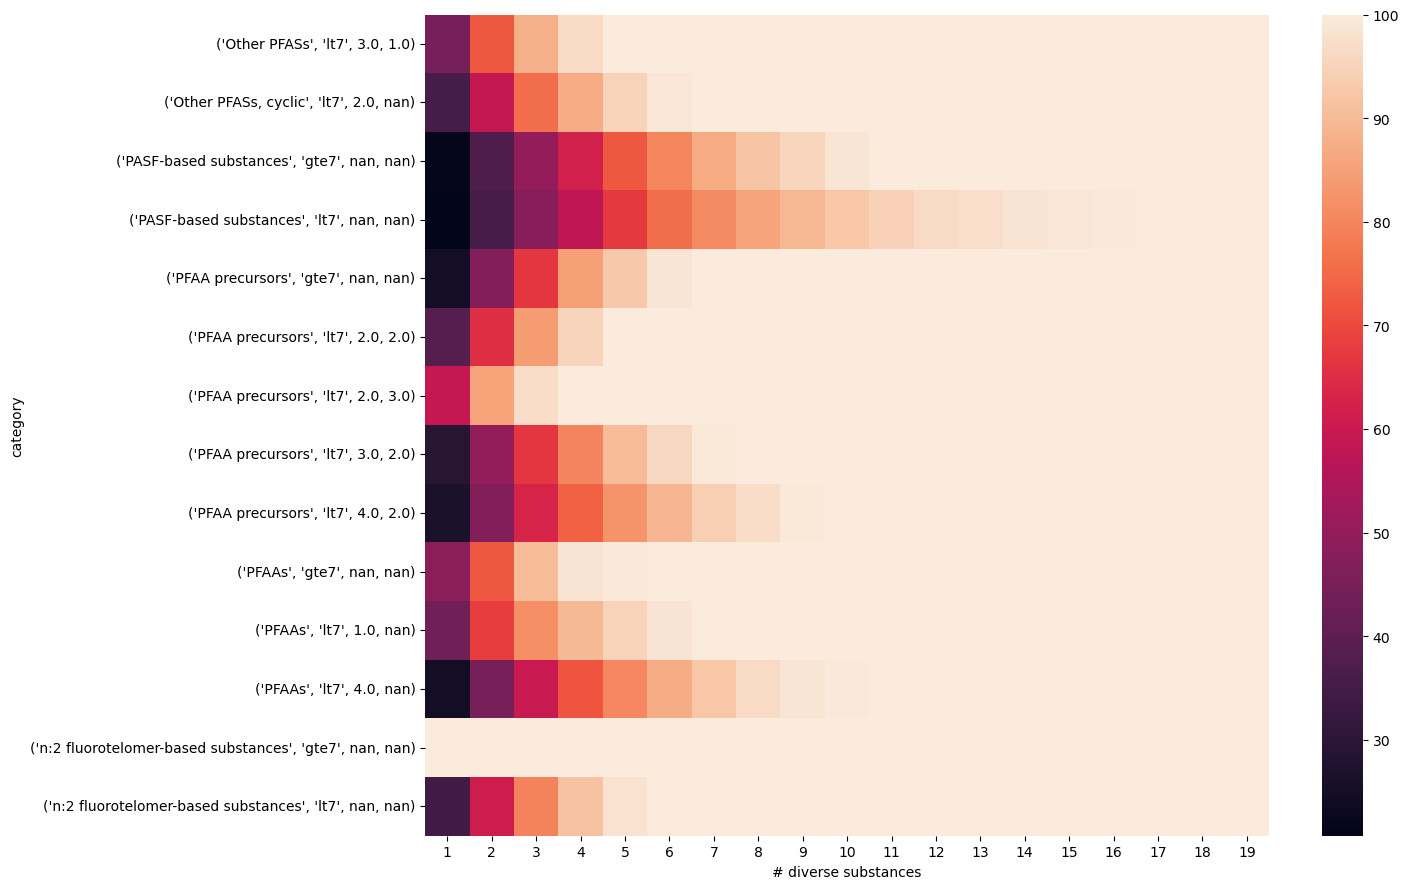

In [66]:
plt.figure(figsize = (15,9))
sns.heatmap(new_df2)
plt.xlabel('# diverse substances')
plt.tight_layout()
#plt.savefig(figures_dir+'structural_diversity_constrained.png', dpi = 300)

In [67]:
div = np.arange(5,100)

In [68]:
mycol = []
for i in div:
    for col in new_df2.columns:
        count = (new_df2[col] > i).sum()
        mycol.append([i, col, count])


In [69]:
dd = pd.DataFrame(mycol)

In [70]:
dd.columns = ['threshold', 'col', 'sum']

In [71]:
dd = pd.pivot_table(dd, index = 'col', columns = 'threshold', values = 'sum')

In [72]:
def how_many(df, threshold = 0.8):
    return df.loc[np.where(df['norm_min'] >threshold)[0][0], '#']

In [73]:
def threshold_3(df, threshold = 3):
    return df.loc[np.where(df['#'] == threshold)[0][0], 'norm_min']

In [74]:
number_chems = {}
for e in range(len(check_lst)):
    a = how_many(check_lst[e]['representative'], threshold = 0.8)
    b = check_lst[e]['label']
    c = np.round(threshold_3(check_lst[e]['representative'], threshold = 3)*100,2)
    d = check_lst[e]['representative'].shape[0]+1
    number_chems[b] =[a,c,d]

In [75]:
df2 = pd.concat([pd.DataFrame(list(number_chems.items())), pd.DataFrame(list(number_chems.items()))[1].apply(pd.Series)], axis=1)
df2.columns = ['terminal_category', 'temp', 'ideal#', '%diversity', 'category_size']
df2.drop(['temp'], axis = 1, inplace =True)

In [76]:
df2['ideal#'].sum()

55.0

In [94]:
df2[df2['%diversity'] >=50]

,terminal_category,ideal#,%diversity,category_size
0,"('n:2 fluorotelomer-based substances', 'lt7', ...",4.0,79.39,7.0
1,"('Other PFASs', 'lt7', 3.0, 1.0)",3.0,87.82,6.0
2,"('Other PFASs, cyclic', 'lt7', 2.0, nan)",4.0,75.73,8.0
3,"('PASF-based substances', 'gte7', nan, nan)",6.0,50.43,18.0
5,"('PFAA precursors', 'gte7', nan, nan)",4.0,66.79,19.0
6,"('PFAA precursors', 'lt7', 2.0, 2.0)",3.0,83.96,6.0
7,"('PFAA precursors', 'lt7', 2.0, 3.0)",2.0,97.06,6.0
8,"('PFAA precursors', 'lt7', 3.0, 2.0)",5.0,66.84,9.0
9,"('PFAA precursors', 'lt7', 4.0, 2.0)",5.0,63.06,11.0
10,"('PFAAs', 'gte7', nan, nan)",3.0,90.00,11.0


In [92]:
df2

,terminal_category,ideal#,%diversity,category_size
0,"('n:2 fluorotelomer-based substances', 'lt7', ...",4.0,79.39,7.0
1,"('Other PFASs', 'lt7', 3.0, 1.0)",3.0,87.82,6.0
2,"('Other PFASs, cyclic', 'lt7', 2.0, nan)",4.0,75.73,8.0
3,"('PASF-based substances', 'gte7', nan, nan)",6.0,50.43,18.0
4,"('PASF-based substances', 'lt7', nan, nan)",7.0,47.72,20.0
5,"('PFAA precursors', 'gte7', nan, nan)",4.0,66.79,19.0
6,"('PFAA precursors', 'lt7', 2.0, 2.0)",3.0,83.96,6.0
7,"('PFAA precursors', 'lt7', 2.0, 3.0)",2.0,97.06,6.0
8,"('PFAA precursors', 'lt7', 3.0, 2.0)",5.0,66.84,9.0
9,"('PFAA precursors', 'lt7', 4.0, 2.0)",5.0,63.06,11.0


In [79]:
df2.describe()

,ideal#,%diversity,category_size
count,14.000000,14.000000,14.000000
mean,3.928571,75.027143,10.500000
std,1.591530,16.396768,5.034496
min,1.000000,47.720000,6.000000
25%,3.000000,63.992500,6.250000
50%,4.000000,77.560000,8.500000
75%,5.000000,86.855000,11.750000
max,7.000000,100.000000,20.000000


In [80]:
df2.to_csv(interim_dir+'diversity_tsca_active_110524.csv')

In [81]:
number_chems2 = []


for e in range(len(check_lst)):
    for i in np.arange(0.1,1,0.1):
        a = how_many(check_lst[e]['representative'], threshold = i)
        #print(a)
        b = check_lst[e]['label']
        number_chems2.append([a,b,i])

In [95]:
df3 = pd.DataFrame(number_chems2, columns = ['#ideal', 'terminal_category', 'threshold'])
df3

,#ideal,terminal_category,threshold
0,1,"('n:2 fluorotelomer-based substances', 'lt7', ...",0.1
1,1,"('n:2 fluorotelomer-based substances', 'lt7', ...",0.2
2,1,"('n:2 fluorotelomer-based substances', 'lt7', ...",0.3
3,2,"('n:2 fluorotelomer-based substances', 'lt7', ...",0.4
4,2,"('n:2 fluorotelomer-based substances', 'lt7', ...",0.5
...,...,...,...
346,2,"('n:2 fluorotelomer-based substances', 'lt7', ...",0.5
347,2,"('n:2 fluorotelomer-based substances', 'lt7', ...",0.6
348,3,"('n:2 fluorotelomer-based substances', 'lt7', ...",0.7
349,4,"('n:2 fluorotelomer-based substances', 'lt7', ...",0.8


In [96]:
df4 = pd.pivot_table(df3, index = 'terminal_category', values = '#ideal', columns = 'threshold')


In [97]:
df4.sum(axis = 0)

threshold
0.1    14
0.2    14
0.3    20
0.4    25
0.5    33
0.6    38
0.7    46
0.8    55
0.9    72
dtype: int64

In [98]:
df4

threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
terminal_category,,,,,,,,,
"('Other PFASs', 'lt7', 3.0, 1.0)",1,1,1,1,2,2,2,3,4
"('Other PFASs, cyclic', 'lt7', 2.0, nan)",1,1,1,2,2,3,3,4,5
"('PASF-based substances', 'gte7', nan, nan)",1,1,2,3,3,4,5,6,8
"('PASF-based substances', 'lt7', nan, nan)",1,1,2,3,4,5,6,7,10
"('PFAA precursors', 'gte7', nan, nan)",1,1,2,2,3,3,4,4,5
"('PFAA precursors', 'lt7', 2.0, 2.0)",1,1,1,2,2,2,3,3,4
"('PFAA precursors', 'lt7', 2.0, 3.0)",1,1,1,1,1,2,2,2,3
"('PFAA precursors', 'lt7', 3.0, 2.0)",1,1,2,2,3,3,4,5,5
"('PFAA precursors', 'lt7', 4.0, 2.0)",1,1,2,2,3,3,4,5,7


Need to add in the centroids for the categories for which the MaxMin was not done. Recall 60 terminal categories for which 46 did not have MaxMin applied because they did not meet the 5 membership threshold.

In [99]:
df4.loc['other'] = list(np.repeat(46,9))

In [100]:
df5 = df4.sum(axis = 0).reset_index()

df5.columns = ['threshold', '#']

In [101]:
df5['threshold'] = (df5.threshold * 100)

In [102]:
df5

,threshold,#
0,10.0,60
1,20.0,60
2,30.0,66
3,40.0,71
4,50.0,79
5,60.0,84
6,70.0,92
7,80.0,101
8,90.0,118


<Figure size 1000x900 with 0 Axes>

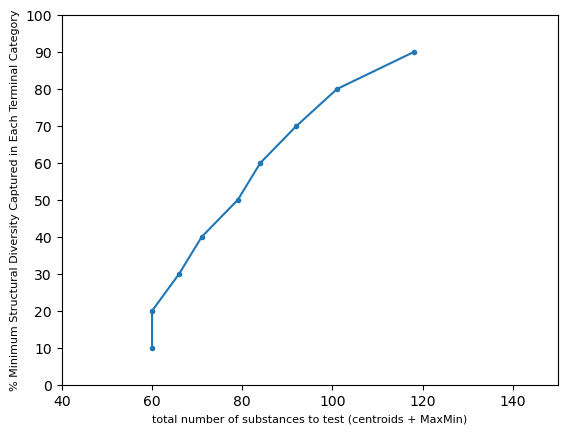

In [103]:
plt.figure(figsize = (10,9))
df5.plot(y = 'threshold', x= '#', marker = '.',legend = False)
plt.xlim(40,150)
plt.ylim(0,100)
plt.yticks(np.arange(0, 100+10, 10.0))
plt.ylabel('% Minimum Structural Diversity Captured in Each Terminal Category', fontsize = 8)
plt.xlabel('total number of substances to test (centroids + MaxMin)', fontsize = 8)
plt.savefig(figures_dir+'Terminal_categorisation_constrained_landscape_110524.png', dpi = 300)
